### Modelling XShooter data with xtool ###

In [1]:
from xtool.data import XShooterData, Order, MultiOrder
from xtool.model import OrderModel, VirtualPixelWavelength, GenericBackground, MoffatTrace, SlopedMoffatTrace
from xtool.model.fitters import Fitter
import numpy as np


from scipy import sparse
from scipy import optimize
import lsqlin

#### Reading XShooter data ####

In [2]:
xd = XShooterData('xtool_ds/')

In [3]:
mask = xd.get_mask(xd.science_data)
current_order = xd[17]
current_order.enable_flags_as_mask()

#### Generating a virtual pixel table for "Wavelength"-pixels ####

In [4]:
virt_pix = VirtualPixelWavelength.from_order(current_order, wavelength_sampling=0.2)
#virt_pix = VirtualPixelWavelength.from_order(current_order)
pixel_table = virt_pix()

#### Initializing the two Models ####

In [5]:
background_mdl = GenericBackground(pixel_table, virt_pix.wavelength_pixels)
trace_mdl = SlopedMoffatTrace(pixel_table, virt_pix.wavelength_pixels)

In [6]:
order_model = OrderModel([background_mdl, trace_mdl])

###### Change fittable parameters ####

In [7]:
order_model.trace_pos = -3
order_model.sigma = 0.5
order_model.sigma_slope = 0.0
order_model.trace_slope = 0.0
order_model.beta.fixed = False

fitter = Fitter(order_model, current_order)

In [8]:
result = fitter.fit_scipy_minimize('Nelder-Mead')

/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Fit finished in 240.230920076 s


/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:247: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/wkerzend/anaconda3/envs/xtool/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:165: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [18]:
import cPickle as pickle
result = pickle.load(open('order_17_psf_fit.pkl'))
result.x = np.array([-2.44004583,  0.00254875,  0.1998531 , -0.00346627,  2.01332594])

In [23]:
#order 15
result.x

array([-2.49888502, -0.01654641,  0.18042513,  0.00730976])

In [11]:
import pyds9
d = pyds9.DS9()

In [12]:
order_model.trace_pos = result.x[0]
#order_model.trace_pos = -2.4
order_model.trace_slope = result.x[1]
order_model.sigma = result.x[2]
order_model.sigma_slope = result.x[3]
#order_model.beta = result.x[3]
model = order_model.evaluate_to_frame(current_order, trace_pos=order_model.trace_pos, sigma=order_model.sigma, 
                                      sigma_slope=order_model.sigma_slope, beta=order_model.beta.value,
                                      trace_slope=order_model.trace_slope)

d.set('frame 1')
d.set_np2arr(current_order.data.filled())
d.set('scale limits 0 5000')

d.set('frame 2')
d.set_np2arr(model.filled())
d.set('scale limits 0 5000')

d.set('frame 3')
d.set_np2arr((current_order.data.filled() - model.filled()) / current_order.uncertainty.filled())


#d.get()

1

In [11]:
test = order_model.model_list[1]

In [22]:
x = array([-2.49888502, -0.01654641,  0.18042513,  0.00730976])
order_model.evaluate(current_order, #solver='lsq', solver_dict={'max_iter':10000},
                     trace_pos=x[0], trace_slope=x[1], sigma=x[2], sigma_slope=x[3])

array([-306.371094  , -492.39569423, -701.67612561, ...,   34.93800516,
         41.25567972,   41.25504488])

In [9]:
order_model.evaluate(current_order, solver='lsq', solver_dict={'max_iter':10000},
                     trace_pos=result.x[0], trace_slope=result.x[1], sigma=result.x[2], sigma_slope=result.x[3])

The maximum number of iterations is exceeded.
Number of iterations: 10000, initial cost: 2.0647e+05, final cost 1.6246e+05, first-order optimality 4.11e-01.


array([ 7815.38274811,  7885.79386275,  7316.35589639, ...,   762.17456212,
         813.66198748,   842.6003785 ])

In [21]:
spec = order_model.model_list[1].to_spectrum()

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


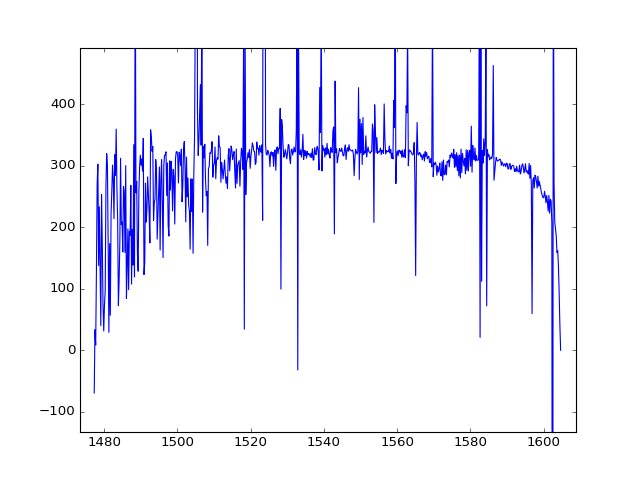

In [22]:
%pylab nbagg
clf()
plot(spec.wavelength.value, spec.flux.value)
np.savetxt('vp_extract.dat', zip(spec.wavelength.value, spec.flux.value))

In [12]:
savefig('ringing_spectrum.pdf')

In [24]:
order_model.model_list[0].generate_design_matrix()

<80307x638 sparse matrix of type '<type 'numpy.float64'>'
	with 105977 stored elements in COOrdinate format>

In [25]:
optimize.lsq_linear?